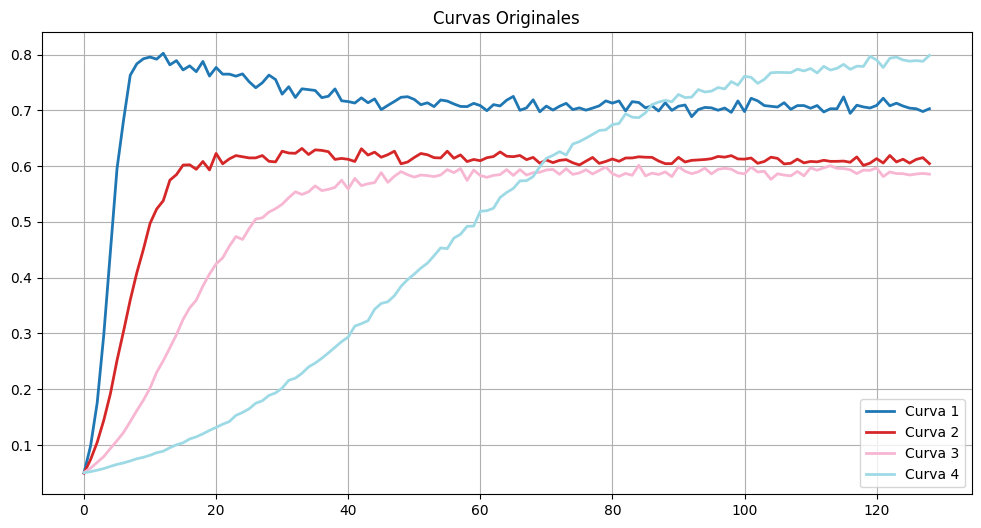

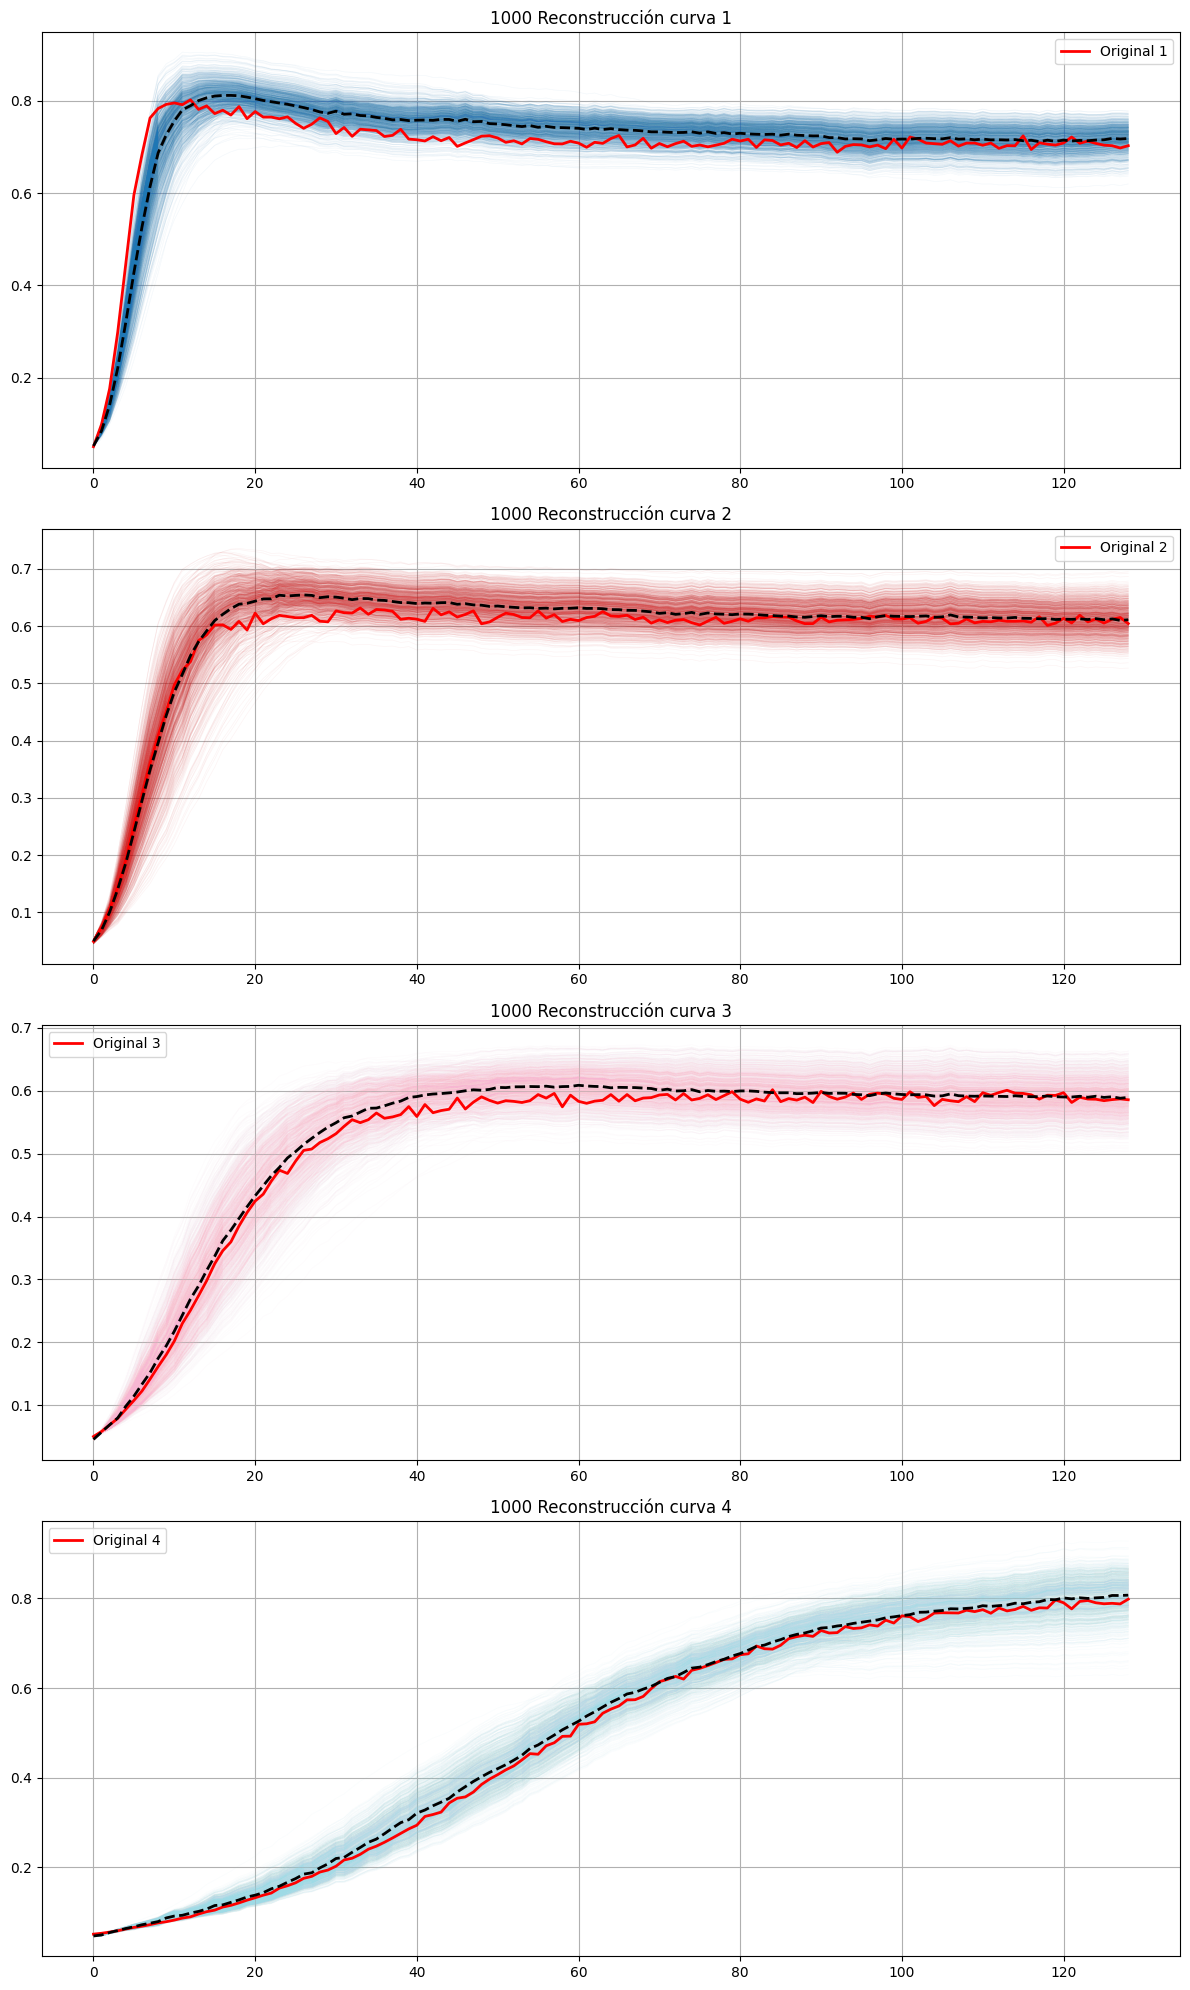

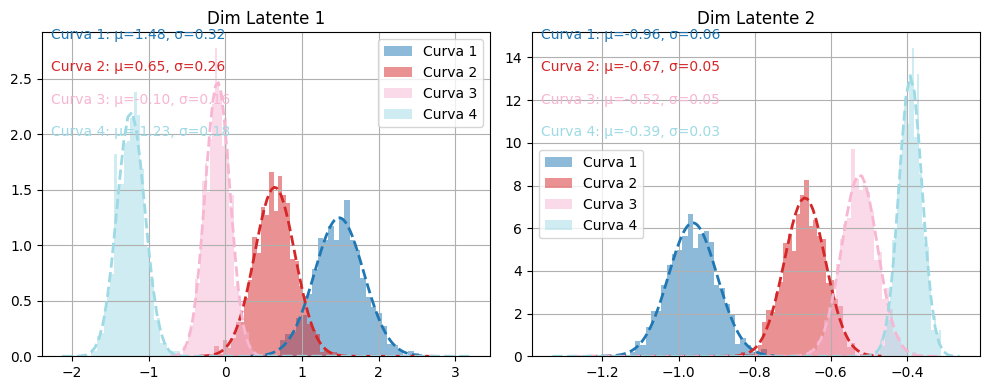

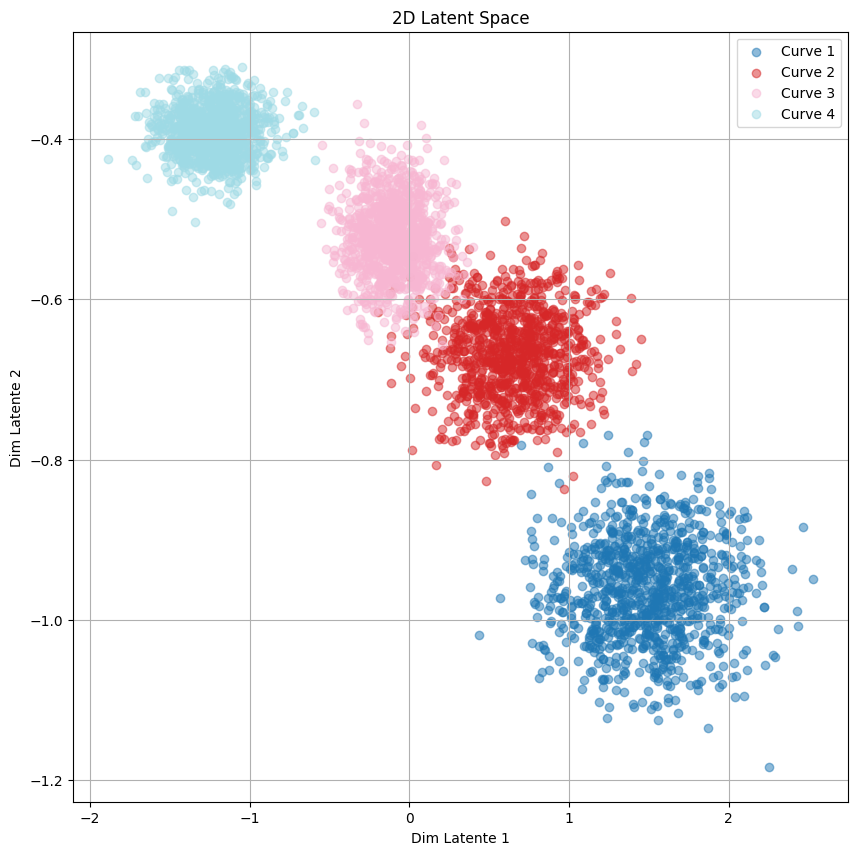

'for i, (orig, recons, codes) in enumerate(zip(originals, reconstructions, latent_codes)):\n    print(f"\nCurve {i+1} Statistics:")\n    print(f"Reconstruction Mean: {recons.mean():.3f}")\n    print(f"Reconstruction Std: {recons.std():.3f}")\n    print("\nLatent Space Statistics:")\n    for dim in range(codes.shape[1]):\n        print(f"Dimension {dim+1}:")\n        print(f"Mean: {codes[:, dim].mean():.3f}")\n        print(f"Std: {codes[:, dim].std():.3f}")'

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


import numpy as np
import matplotlib.pyplot as plt
from config import model_config, hp
from AE.model.autoencoder import Autoencoder
from train import train
from VAE.models.VAE import VAE
from VAE.models.AE import AE
import pickle

def visualize_vae_multiple_samples(model, X, n_curves=2, n_samples=1000, alpha=0.1):
    # Select n_curves random curves
    indices = np.random.randint(0, X.shape[0], size=n_curves)
    subsets = [X[idx:idx+1, :, :].to(DEVICE) for idx in indices]
    originals = [subset.squeeze(0).squeeze(0).cpu().numpy() for subset in subsets]
    
    # Generate multiple reconstructions for each curve
    reconstructions = []
    latent_codes = []
    
    # Colors for different curves
    colors = plt.cm.tab20(np.linspace(0, 1, n_curves))
    
    # Plot comparing original curves
    plt.figure(figsize=(12, 6))
    for i, (orig, color) in enumerate(zip(originals, colors)):
        plt.plot(orig, color=color, linewidth=2, label=f'Curva {i+1}')
    plt.title('Curvas Originales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    model.eval()
    with torch.no_grad():
        for subset in subsets:
            recons_curve = []
            codes_curve = []
            for _ in range(n_samples):
                out, code, *_ = model(subset.squeeze(0))
                recons_curve.append(out.squeeze(0).squeeze(0).cpu().numpy())
                codes_curve.append(code.squeeze(0).cpu().numpy())
            reconstructions.append(np.array(recons_curve))
            latent_codes.append(np.array(codes_curve))
    
    # Plot reconstructions vs originals
    fig, axs = plt.subplots(n_curves, 1, figsize=(12, 5*n_curves))
    if n_curves == 1:
        axs = [axs]
    
    # Plot for each curve
    for i, (recons, orig, color) in enumerate(zip(reconstructions, originals, colors)):
        # Plot reconstructions
        for recon in recons:
            axs[i].plot(recon, '-', color=color, alpha=alpha, linewidth=0.5)
        # Plot original
        axs[i].plot(orig, 'r-', linewidth=2, label=f'Original {i+1}')
        axs[i].set_title(f'{n_samples} Reconstrucción curva {i+1}')
        axs[i].legend()
        axs[i].grid(True)
        
        # Add mean reconstruction
        mean_recon = recons.mean(axis=0)
        axs[i].plot(mean_recon, '--', color='black', linewidth=2, label='Reconstrucción Media')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize latent space distributions
    n_latent_dims = latent_codes[0].shape[1]
    
    # Histograms for each dimension
    fig, axs = plt.subplots(1, n_latent_dims, figsize=(5*n_latent_dims, 4))
    if n_latent_dims == 1:
        axs = [axs]
    
    for dim in range(n_latent_dims):
        # Histogram for all curves
        for i, (codes, color) in enumerate(zip(latent_codes, colors)):
            axs[dim].hist(codes[:, dim], bins=30, density=True, alpha=0.5, 
                         color=color, label=f'Curva {i+1}')
            
            # Fit normal distribution
            mu, std = stats.norm.fit(codes[:, dim])
            xmin, xmax = axs[dim].get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = stats.norm.pdf(x, mu, std)
            axs[dim].plot(x, p, '--', color=color, linewidth=2)
            axs[dim].text(0.02, 0.98 - i*0.1, f'Curva {i+1}: μ={mu:.2f}, σ={std:.2f}',
                         transform=axs[dim].transAxes, color=color)
        
        axs[dim].set_title(f'Dim Latente {dim+1}')
        axs[dim].grid(True)
        axs[dim].legend()
    
    plt.tight_layout()
    plt.show()
    
    # If 2D latent space, show combined scatter plot
    if n_latent_dims == 2:
        plt.figure(figsize=(10, 10))
        for i, (codes, color) in enumerate(zip(latent_codes, colors)):
            plt.scatter(codes[:, 0], codes[:, 1], alpha=0.5, 
                       color=color, label=f'Curve {i+1}')
        plt.title('2D Latent Space')
        plt.xlabel('Dim Latente 1')
        plt.ylabel('Dim Latente 2')
        plt.grid(True)
        plt.legend()
        plt.show()
        
    return originals, reconstructions, latent_codes

# Your data loading code
DEVICE = 'mps'
with open('data/VAE_129.pkl', 'rb') as file:
    X = pickle.load(file)

X = (X - X.min())/(X.max() - X.min())
X = torch.Tensor(X)
X = X.reshape((X.shape[0], 1, -1)).to(torch.float32)

# Load model
model = VAE(model_config).to(DEVICE)
model.load_state_dict(torch.load('model_ckpts/model.pth'))

# Run visualization with desired number of curves
n_curves = 4  # Change this to compare different number of curves
originals, reconstructions, latent_codes = visualize_vae_multiple_samples(
    model, X, n_curves=n_curves, n_samples=1000, alpha=0.05
)

# Print statistics for all curves
'''for i, (orig, recons, codes) in enumerate(zip(originals, reconstructions, latent_codes)):
    print(f"\nCurve {i+1} Statistics:")
    print(f"Reconstruction Mean: {recons.mean():.3f}")
    print(f"Reconstruction Std: {recons.std():.3f}")
    print("\nLatent Space Statistics:")
    for dim in range(codes.shape[1]):
        print(f"Dimension {dim+1}:")
        print(f"Mean: {codes[:, dim].mean():.3f}")
        print(f"Std: {codes[:, dim].std():.3f}")'''